# Data Prepraration

In [332]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import csv

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


## Data Collection

In [213]:
FILE_PATH = '../data/TeleCom_Data-1.csv'

def format_row(row):
    # format row in the raw data file
    row = row[0]
    row = row.replace('"','')
    row = row.split(';')
    return row

def read_raw_data(file_path='TeleCom_Data-1.csv'):
    '''
    since the raw csv file cannot be read directly by the pandas read_csv function,
    we need to read it in another way and return a dataframe from it.
    '''
    with open(file_path, newline='') as f:
        # data is a list, each element is a row from the file, each row is a list with len 1
        data = csv.reader(f)

        # read the first
        header = next(data)
        header = format_row(header)

        new_data = []

        for row in data:
            row = format_row(row)
            new_data.append(row)

        # create a dict with keys are headers and values are columns
        data_dict = defaultdict(list)

        for row in new_data:
            for i in range(len(row)):
                data_dict[header[i]].append(row[i])

    return pd.DataFrame(data=data_dict)

# read generated data
df = read_raw_data(file_path=FILE_PATH)

print('Data shape:', df.shape)
print(df.columns)
df.head(3)

Data shape: (41180, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


## Data Preprocessing

### Drop Duplicated

In [214]:
# drop duplicate samples
print('Number of duplicate samples:', len(df[df.duplicated()]))
df = df.drop_duplicates(keep='first')
print('Number of samples after removing duplicate samples:', len(df))

Number of duplicate samples: 12
Number of samples after removing duplicate samples: 41168


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41168 entries, 0 to 41179
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             41168 non-null  object
 1   job             41168 non-null  object
 2   marital         41168 non-null  object
 3   education       41168 non-null  object
 4   default         41168 non-null  object
 5   housing         41168 non-null  object
 6   loan            41168 non-null  object
 7   contact         41168 non-null  object
 8   month           41168 non-null  object
 9   day_of_week     41168 non-null  object
 10  duration        41168 non-null  object
 11  campaign        41168 non-null  object
 12  pdays           41168 non-null  object
 13  previous        41168 non-null  object
 14  poutcome        41168 non-null  object
 15  emp.var.rate    41168 non-null  object
 16  cons.price.idx  41168 non-null  object
 17  cons.conf.idx   41168 non-null  object
 18  euribor3m  

### Format Features

In [216]:
all_feats = df.columns

cate_feats = ["job", "marital", "education", "default", "housing", "loan",
            "contact", "month", "day_of_week", "poutcome", "y"]

numeric_feats = [feat for feat in all_feats if feat not in cate_feats]

int_feats = ['age', 'pdays', 'previous']
float_feats = [feat for feat in numeric_feats if feat not in int_feats]

df[int_feats] = df[int_feats].astype(int)
df[float_feats] = df[float_feats].astype(float)
df[cate_feats] = df[cate_feats].astype(str)

# Models Development

## Data Setup

### Generate Cross Validation Data

In [217]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Split Train Test Data

In [482]:
X = df.drop(columns='y')
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

print(X.shape)
print(y_test.shape[0]/y_train.shape[0])


X train shape: (32934, 20)
y train shape: (32934,)
X test shape: (8234, 20)
y test shape: (8234,)
(41168, 20)
0.2500151818789093


/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and

Text(0.5, 1.0, 'y distribution in Test Set')

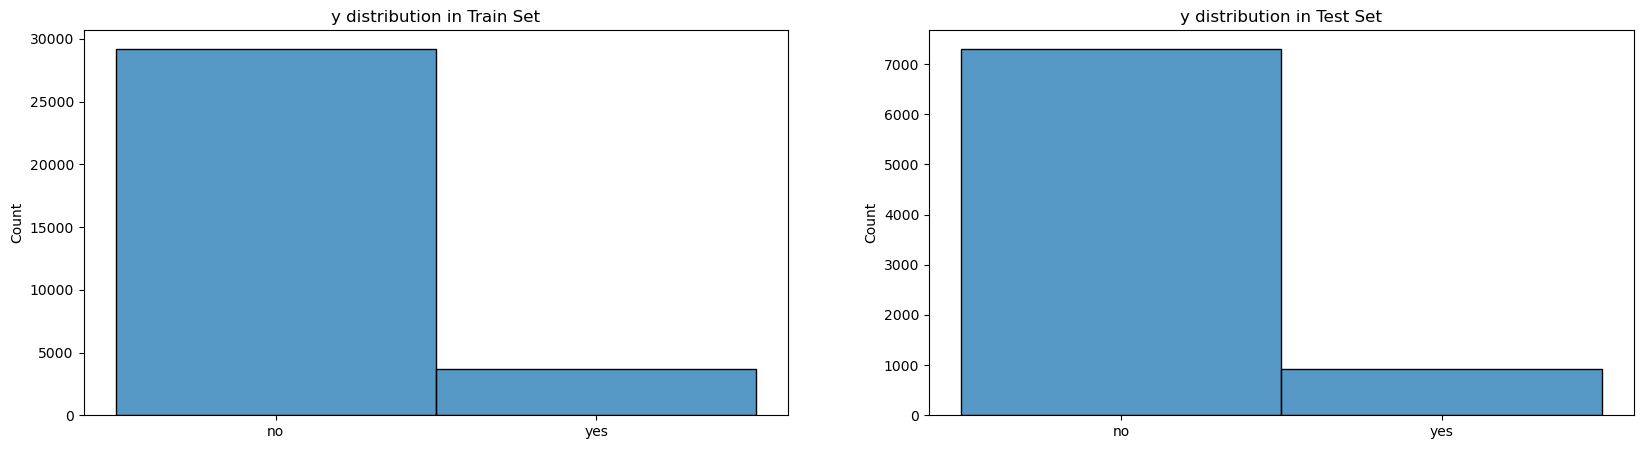

In [219]:
# plot y distribution in train set and test set

fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(y_train.ravel(), ax=axes[0])
axes[0].set_title('y distribution in Train Set')
sns.histplot(y_test.ravel(),  ax=axes[1])
axes[1].set_title('y distribution in Test Set')

### Generate Balanced Data with SMOTE-NC

In [220]:
from imblearn.over_sampling import SMOTENC

# get cate feat id in X_train
cate_indices = [X_train.columns.get_loc(feat) for feat in cate_feats if feat in X_train.columns]

num_no = (y_train == 'no').sum()
num_yes = (y_train == 'yes').sum()

print('Before Balancing')
print('Number of No class:', num_no)
print('Number of Yes class:', num_yes)
print('Yes/No Ratio:', round(num_yes/num_no*100, 2))

smote_nc = SMOTENC(random_state=42, categorical_features=cate_indices)

X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)

num_no_balanced = (y_train_balanced == 'no').sum()
num_yes_balanced = (y_train_balanced == 'yes').sum()

print('\nAfter Balancing')
print('Number of No class:', num_no_balanced)
print('Number of Yes class:', num_yes_balanced)
print('Yes/No Ratio:', round(num_yes_balanced/num_no_balanced*100, 2))

Before Balancing
Number of No class: 29224
Number of Yes class: 3710
Yes/No Ratio: 12.7

After Balancing
Number of No class: 29224
Number of Yes class: 29224
Yes/No Ratio: 100.0


### Encode categorical features

In [447]:
# encode train and test dataset
cate_feats = ["job", "marital", "education", "default", "housing", "loan",
            "contact", "month", "day_of_week", "poutcome", "y"]

def get_encode_cate_dict(df, cate_feats):
    encode_dict = {}
    for feat in cate_feats:
        vals = df[feat].unique()
        encode = {cat_val: encode_val for (encode_val, cat_val) in enumerate(vals)}
        # replace values in df
        encode_dict[feat] = encode
    return encode_dict


def encode_cate_data(df, encode_dict, type='input'):
    if type == 'output':
        df = df.map(encode_dict['y'])
        return df

    for feat in encode_dict.keys():
        if feat == 'y':
            continue
        df[feat] = df[feat].map(encode_dict[feat])
    return df

encode_dict = get_encode_cate_dict(df, cate_feats)

X_train = encode_cate_data(X_train, encode_dict)
y_train = encode_cate_data(y_train, encode_dict, type='output')

X_test = encode_cate_data(X_test, encode_dict)
y_test = encode_cate_data(y_test, encode_dict, type='output')

X_train_balanced = encode_cate_data(X_train_balanced, encode_dict)
y_train_balanced = encode_cate_data(y_train_balanced, encode_dict, type='output')

X = encode_cate_data(X, encode_dict)
y = encode_cate_data(y, encode_dict, type='output')

## Model Experiments

In [242]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [363]:
# Define evaluation functions

models = [
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("GrandientBoosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier()),
]

def eval_model(model, X_train, y_train, X_test, y_test):
    # return df of model performance
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    precision = precision_score(y_test, preds)
    # return classification_report_to_df(y_test, preds), preds
    return {'precision': precision, 'recall': recall, 'f1_score': f1, 'preds': preds}

def eval_multi_models(models, X_train, y_train, X_test, y_test):
    # return df of multi models performance
    model_reports = defaultdict(dict)
    for model_name, model in models:
        results = eval_model(model, X_train, y_train, X_test, y_test)
        print(f"{model_name}: Precision: {results['precision']} \t Recall: {results['recall']} \t F1 Score: {results['f1_score']}")
        model_reports[model_name] = results
    return model_reports

def cross_val_eval_model(model, X, y, cv):
    preds = cross_val_predict(model, X, y, cv=cv)

    # return classification_report_to_df(y, preds), preds

    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    precision = precision_score(y, preds)
    return {'precision': precision, 'recall': recall, 'f1_score': f1, 'preds': preds}

def cross_val_eval_multi_models(models, X, y, cv):
    model_reports = defaultdict(dict)
    for model_name, model in models:
        results = cross_val_eval_model(model, X, y, cv)
        print(f"{model_name}: Precision: {results['precision']} \t Recall: {results['recall']} \t F1 Score: {results['f1_score']}")
        model_reports[model_name] = results
    return model_reports

### Cross Validation Benchmarking

In [364]:
# cross eval multi models
model_cross_val_reports = cross_val_eval_multi_models(models, X, y, cv)

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Logistic Regression: Precision: 0.6547314578005116 	 Recall: 0.3864567608367479 	 F1 Score: 0.4860320043395715
Decision Tree: Precision: 0.5074626865671642 	 Recall: 0.5279275393573432 	 F1 Score: 0.5174928654476272
Random Forest: Precision: 0.6565880721220527 	 Recall: 0.5104593487168427 	 F1 Score: 0.5743751516622179
GrandientBoosting: Precision: 0.6631550513236089 	 Recall: 0.5294371360793616 	 F1 Score: 0.5887996162609426
XGBoost: Precision: 0.641301562900333 	 Recall: 0.5397886564589174 	 F1 Score: 0.5861826697892271


In [375]:
def visualize_score_mutli_models(model_reports, ax, title='', xlabel='', ylabel='', metric='f1_score'):    
    models = [model_name for model_name in model_reports]
    scores = [model_reports[model_name][metric] for model_name in models]

    precisons = [model_reports[model_name]['precision'] for model_name in models]
    recalls = [model_reports[model_name]['recall'] for model_name in models]
    f1_scores = [model_reports[model_name]['f1_score'] for model_name in models]

    df_vis = pd.DataFrame(data={'model': models, 'precision': precisons, 'recall': recalls, 'f1_score': f1_scores, 
                                'target_score': scores})

    sns.lineplot(data=df_vis, x='model', y='target_score', ax=ax)

    # sns.lineplot(data=df_vis, x='model', y='precision', ax=ax, label='Precision')
    # sns.lineplot(data=df_vis, x='model', y='recall', ax=ax, label='Recall')
    # sns.lineplot(data=df_vis, x='model', y='f1_score', ax=ax, label='F1 Score')
    
    # add highlight points
    for x, y in zip(df_vis['model'].values, df_vis['target_score'].values):
        plt.scatter(x, y, color='red', marker='o', s=50)
        plt.text(x, y+0.001, f'{str(round(y, 3))}', fontsize=10, ha='left', 
                va='bottom', color='red', fontweight='bold')  # Annotate the point

    # Remove axes splines
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be r

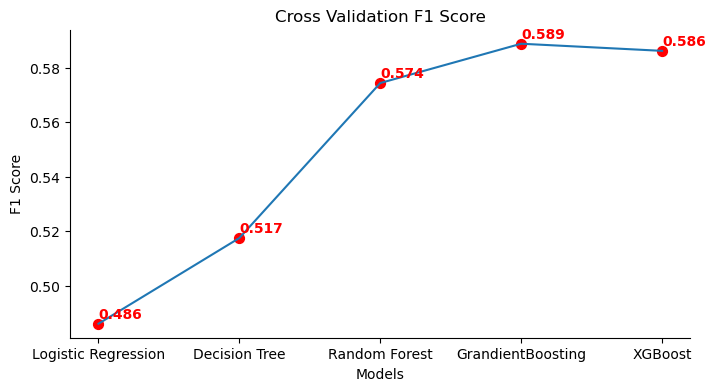

In [378]:
fig, ax = plt.subplots(figsize=(8, 4))

visualize_score_mutli_models(model_cross_val_reports, ax,
                            title='Cross Validation F1 Score',
                            xlabel='Models', ylabel='F1 Score')

### Test Dataset Benchmarking

In [377]:
# cross eval multi models
model_test_reports = eval_multi_models(models, X_train, y_train, X_test, y_test)

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Precision: 0.6764705882352942 	 Recall: 0.3969795037756203 	 F1 Score: 0.5003399048266486
Decision Tree: Precision: 0.5157894736842106 	 Recall: 0.5285868392664509 	 F1 Score: 0.5221097496004262
Random Forest: Precision: 0.675561797752809 	 Recall: 0.5188781014023732 	 F1 Score: 0.5869432580841976
GrandientBoosting: Precision: 0.6808803301237965 	 Recall: 0.5339805825242718 	 F1 Score: 0.5985489721886336
XGBoost: Precision: 0.6619897959183674 	 Recall: 0.5598705501618123 	 F1 Score: 0.6066627703097605


/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be r

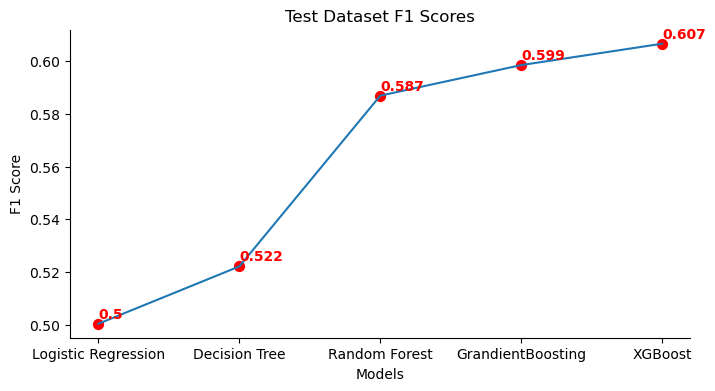

In [379]:
fig, ax = plt.subplots(figsize=(8, 4))

visualize_score_mutli_models(model_test_reports, ax,
                            title='Test Dataset F1 Scores',
                            xlabel='Models', ylabel='F1 Score')

We the particularly care about the Recall score of 'No' class, which indicates the percentage of real subcribed customers that we can capture.

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be r

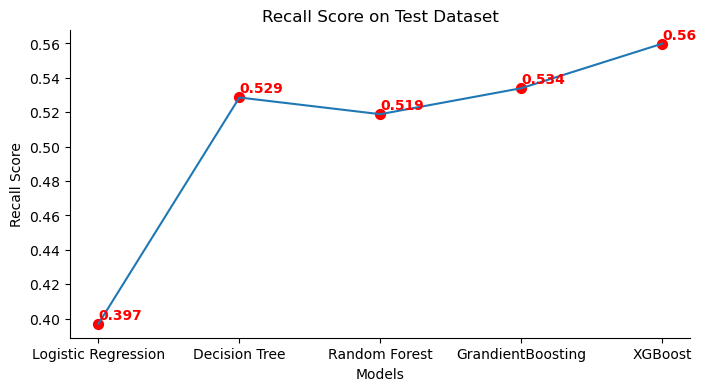

In [381]:
fig, ax = plt.subplots(figsize=(8, 4))

visualize_score_mutli_models(model_test_reports, ax,
                            title='Recall Score on Test Dataset',
                            xlabel='Models', ylabel='Recall Score', 
                            metric='recall')

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be r

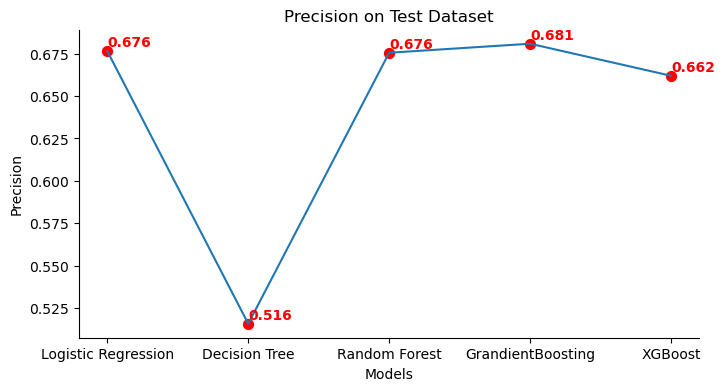

In [480]:
fig, ax = plt.subplots(figsize=(8, 4))

visualize_score_mutli_models(model_test_reports, ax,
                            title='Precision on Test Dataset',
                            xlabel='Models', ylabel='Precision', 
                            metric='precision')

XGBoost still outstanding other models in terms of Recall Score. Hence, we will focus on optimizing XGBoost with more complex methods.

### XGBoost Optimization

#### Apply Balanced Data with SMOTE-NC

In [384]:
xgb = XGBClassifier()

xgb_results = eval_model(xgb, X_train, y_train, X_test, y_test)
xgb_sm_results = eval_model(xgb, X_train_balanced, y_train_balanced, X_test, y_test)

print('XGBoost with original data')
print(f"Recall: {xgb_results['recall']} \t F1 Score: {xgb_results['f1_score']}")
print('\nXGBoost with balanced data using SMOTE-NC')
print(f"Recall: {xgb_sm_results['recall']} \t F1 Score: {xgb_sm_results['f1_score']}")

XGBoost with original data
Recall: 0.5598705501618123 	 F1 Score: 0.6066627703097605

XGBoost with balanced data using SMOTE-NC
Recall: 0.6634304207119741 	 F1 Score: 0.6246825799898426


#### Optimize Parameters with TPE

In [335]:
xgb_params_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 1),
}

def xgb_objective(params):
    model = XGBClassifier(
        learning_rate = params['learning_rate'],
        n_estimators = int(params['n_estimators']),
        max_depth = int(params['max_depth']),
        min_child_weight = params['min_child_weight'],
        subsample = params['subsample'],
        gamma = params['gamma']
    )
    f1_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='f1')
    return 1 - f1_scores.mean()  # Minimize 1 - F1-Score

# Create a Trials object to keep track of the optimization process
trials = Trials()

xgb_best_params = fmin(fn=xgb_objective, space=xgb_params_space, algo=tpe.suggest, 
                        max_evals=50, trials=trials)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [02:12<00:00,  2.65s/trial, best loss: 0.07068715857703745]


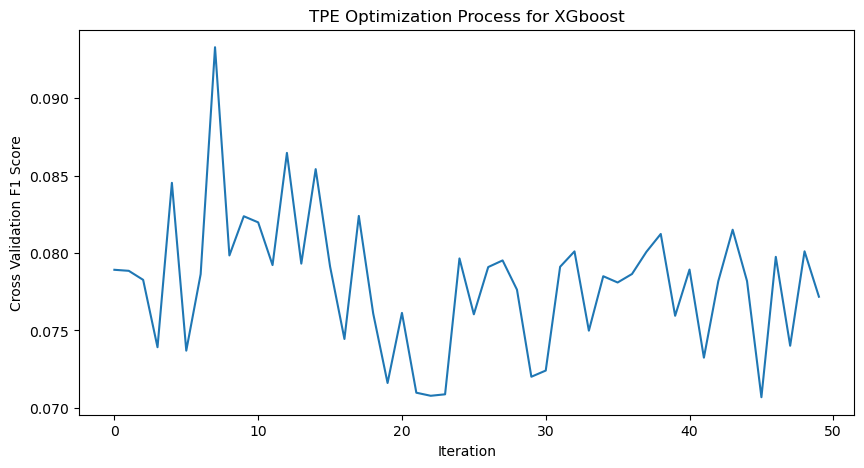

Best parameters: {'gamma': 0.5673261963317846, 'learning_rate': 0.05114782562692015, 'max_depth': 10.0, 'min_child_weight': 6.0, 'n_estimators': 61.0, 'subsample': 0.6484666869514822}


In [338]:
# Visualize the optimization process
losses = [trial['result']['loss'] for trial in trials.trials]

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Cross Validation F1 Score')
plt.title('TPE Optimization Process for XGboost')
plt.show()

print('Best parameters:', xgb_best_params)

In [382]:
xgb_sm_tpe = XGBClassifier(
        learning_rate = xgb_best_params['learning_rate'],
        n_estimators = int(xgb_best_params['n_estimators']),
        max_depth = int(xgb_best_params['max_depth']),
        min_child_weight = xgb_best_params['min_child_weight'],
        subsample = xgb_best_params['subsample'],
        gamma = xgb_best_params['gamma']
    )

xgb_sm_tpe_results = eval_model(xgb_sm_tpe, X_train_balanced, y_train_balanced, X_test, y_test)

# print('XGBoost')
# print(f"Recall: {xgb_results['recall']} \t F1 Score: {xgb_results['f1_score']}")
# print('\nXGBoost + SMOTE-NC')
# print(f"Recall: {xgb_sm_results['recall']} \t F1 Score: {xgb_sm_results['f1_score']}")
# print('\nXGBoost + SMOTE-NC + TPE')
# print(f"Recall: {xgb_sm_tpe_results['recall']} \t F1 Score: {xgb_sm_tpe_results['f1_score']}")

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be r

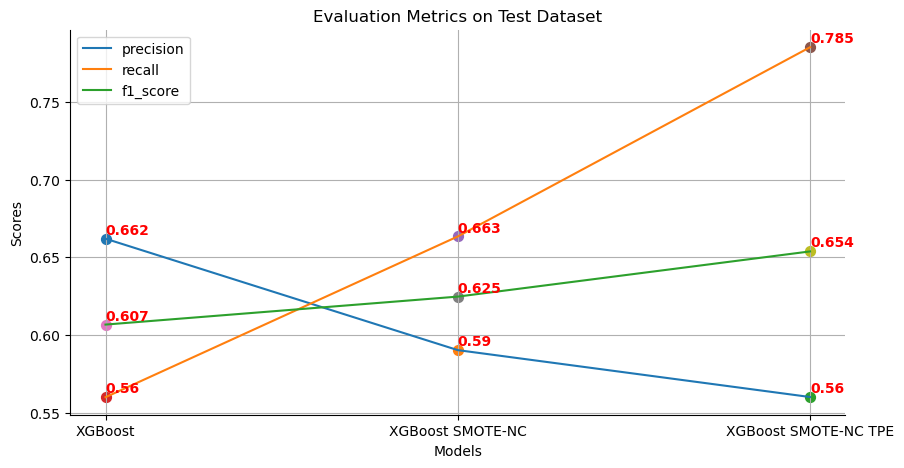

In [416]:
fig, ax = plt.subplots(figsize=(10,5))

metrics = ['precision', 'recall', 'f1_score']

for metric in metrics:
    model_scores = [xgb_results[metric], xgb_sm_results[metric], xgb_sm_tpe_results[metric]]
    model_names = ['XGBoost', 'XGBoost SMOTE-NC', 'XGBoost SMOTE-NC TPE']

    sns.lineplot(y=model_scores, x=model_names, label=metric, ax=ax)

    for name, score in zip(model_names, model_scores):
        plt.scatter(name, score, marker='o', s=50)
        plt.text(name, score+0.001, f'{str(round(score, 3))}', fontsize=10, ha='left', 
                    va='bottom', color='red', fontweight='bold')  # Annotate the point
    
ax.set_title('Evaluation Metrics on Test Dataset')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
plt.grid(True)

# Remove axes splines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

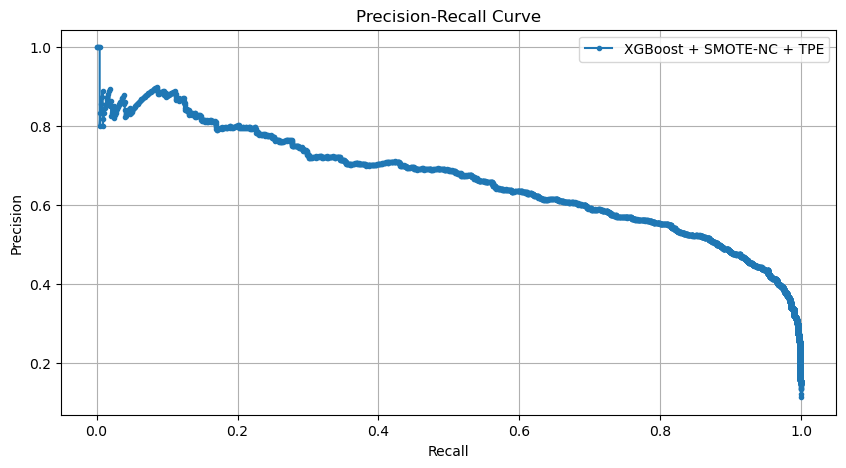

In [414]:
# get predict probs for positive class (at last column)
xgb_preds_probs = XGBClassifier().fit(X_train, y_train).predict_proba(X_test)[:, -1]
xgb_sm_preds_probs = XGBClassifier().fit(X_train_balanced, y_train_balanced).predict_proba(X_test)[:, -1]
xgb_sm_tpe_preds_probs = XGBClassifier(
        learning_rate = xgb_best_params['learning_rate'],
        n_estimators = int(xgb_best_params['n_estimators']),
        max_depth = int(xgb_best_params['max_depth']),
        min_child_weight = xgb_best_params['min_child_weight'],
        subsample = xgb_best_params['subsample'],
        gamma = xgb_best_params['gamma']
    ).fit(X_train_balanced, y_train_balanced).predict_proba(X_test)[:, -1]

# calculate precision recall curves
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, xgb_preds_probs)
precision_xgb_sm, recall_xgb_sm, thresholds_xgb_sm = precision_recall_curve(y_test, xgb_sm_preds_probs)
precision_xgb_sm_tpe, recall_xgb_sm_tpe, thresholds_xgb_sm_tpe = precision_recall_curve(y_test, xgb_sm_tpe_preds_probs)

fig, ax = plt.subplots(figsize=(10, 5))

# # Plot the precision-recall curve
# plt.plot(recall_xgb, precision_xgb, marker='*', label='XGBoost')
# plt.plot(recall_xgb_sm, precision_xgb_sm, marker='*', label='XGBoost + SMOTE-NC')
plt.plot(recall_xgb_sm_tpe, precision_xgb_sm_tpe, marker='.', label='XGBoost + SMOTE-NC + TPE')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.show()

In [415]:
# convert to f score
fscores_xgb_sm_tpe = (2 * precision_xgb_sm_tpe * recall_xgb_sm_tpe) / (precision_xgb_sm_tpe + recall_xgb_sm_tpe)
# locate the index of the largest f score
ix = np.argmax(fscores_xgb_sm_tpe)

xgb_sm_tpe_best_thres = thresholds_xgb_sm_tpe[ix]
print('Best threshold for XGBoost + SMOTE + TPE:', xgb_sm_tpe_best_thres)
xgb_sm_tpe_best_preds = [0 if prob < xgb_sm_tpe_best_thres else 1 for prob in xgb_sm_tpe_preds_probs]

Best threshold for XGBoost + SMOTE + TPE: 0.46502292


/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be r

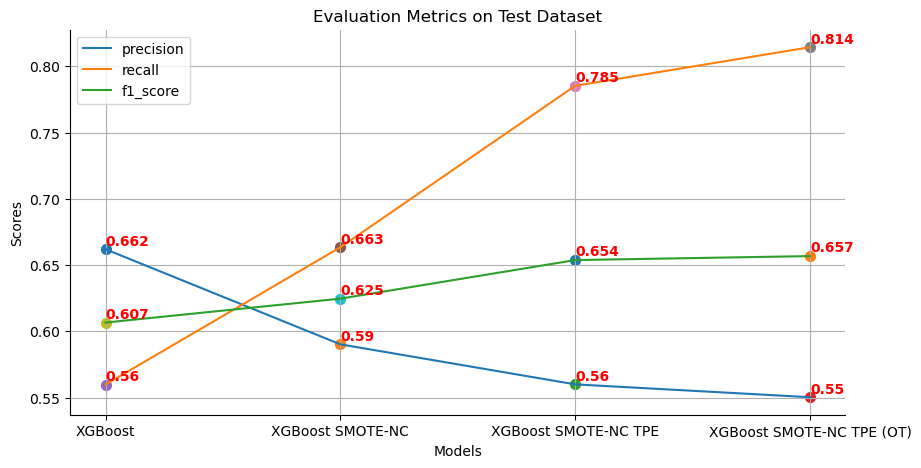

In [487]:
fig, ax = plt.subplots(figsize=(10,5))

metrics = ['precision', 'recall', 'f1_score']

xgb_sm_tpe_best_thres_results = {
    'precision': precision_score(y_test, xgb_sm_tpe_best_preds),
    'recall': recall_score(y_test, xgb_sm_tpe_best_preds),
    'f1_score': f1_score(y_test, xgb_sm_tpe_best_preds)
}

for metric in metrics:
    model_scores = [xgb_results[metric], xgb_sm_results[metric], xgb_sm_tpe_results[metric], 
                    xgb_sm_tpe_best_thres_results[metric]]
    model_names = ['XGBoost', 'XGBoost SMOTE-NC', 'XGBoost SMOTE-NC TPE', 'XGBoost SMOTE-NC TPE (OT)']

    sns.lineplot(y=model_scores, x=model_names, label=metric, ax=ax)

    for name, score in zip(model_names, model_scores):
        plt.scatter(name, score, marker='o', s=50)
        plt.text(name, score+0.001, f'{str(round(score, 3))}', fontsize=10, ha='left', 
                    va='bottom', color='red', fontweight='bold')  # Annotate the point
    
ax.set_title('Evaluation Metrics on Test Dataset')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
plt.grid(True)

# Remove axes splines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

# Insights

## Customer Segmentation

In this phase, we will utilize the best model from previous phase, fit and evaluate on the whole dataset

In [448]:
segment_thres = [0, 0.4, 0.7, 1]
segment_groups = ['Low Likelihood', 'Intermediate Likelihood', 'High Likelihood']

# dict to decode encoded categorical features
decode_dict = defaultdict(dict)

for feat in encode_dict:
    decode_dict[feat] = {v: k for (k, v) in zip(encode_dict[feat].keys(), encode_dict[feat].values())}

def get_group_name(prob):
    if prob < 0.4:
        return 'Low Likelihood'
    elif prob < 0.7:
        return 'Intermediate Likelihood'
    return 'High Likelihood'

# analyze test data
df_customers = X_test
# add prob column
df_customers['subcribe_prob'] = xgb_sm_tpe_preds_probs
# add group column
df_customers['group'] = df_customers['subcribe_prob'].apply(get_group_name)

# get all current feats
utilized_feats = X_test.columns

# decode categorical features
for feat in decode_dict:
    if feat in utilized_feats:
        df_customers[feat] = df_customers[feat].map(decode_dict[feat])

df_customers.head(4)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subcribe_prob,group
11855,47,admin.,married,basic.9y,no,yes,no,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0.022160,Low Likelihood
11185,41,blue-collar,married,basic.4y,unknown,yes,no,telephone,jun,thu,...,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0.022073,Low Likelihood
12431,42,admin.,single,university.degree,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0.090227,Low Likelihood
28928,39,blue-collar,divorced,basic.6y,no,yes,no,cellular,apr,fri,...,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0.141715,Low Likelihood


In [457]:
groups = df_customers['group'].unique()

for group in groups:
    print(f'Number of customer of group {group}: {len(df_customers[df_customers.group == group])}')

Number of customer of group Low Likelihood: 6732
Number of customer of group Intermediate Likelihood: 692
Number of customer of group High Likelihood: 810


In [469]:
df_customers.drop(columns='subcribe_prob', axis=1, inplace=True)

# Customer Segments Insights

In [ ]:
df_low = df_customers[df_customers.group == 'Low Likelihood']
df_inter = df_customers[df_customers.group == 'Intermediate Likelihood']
df_high = df_customers[df_customers.group == 'High Likelihood']

### Insights from Previous Campaign Outcome

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



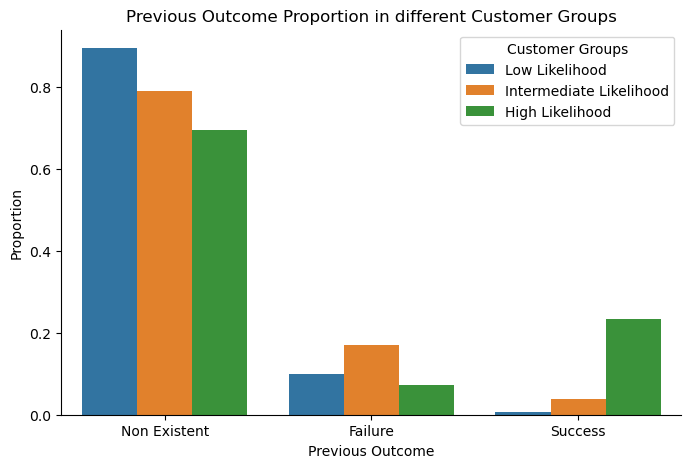

In [603]:
feat = 'poutcome'

df_groups = [df_low, df_inter, df_high]
group_names = ['Low Likelihood', 'Intermediate Likelihood', 'High Likelihood']

df_customers_normlized = [df_group[feat].value_counts(normalize=True).reset_index() 
                          for df_group in df_groups]

for i, df in enumerate(df_customers_normlized):
    df['group'] = group_names[i]

combined_normalized = pd.concat(df_customers_normlized, ignore_index=True)

# Plot the distribution of the categorical feature
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=combined_normalized, x=feat, y='proportion', hue='group')
ax.set_title('Previous Outcome Proportion in different Customer Groups')
ax.set_xlabel('Previous Outcome')
ax.set_ylabel('Proportion')
ax.legend(title='Customer Groups')

# Remove axes splines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(['Non Existent', 'Failure', 'Success'])

plt.show()

The company should focus in customers who already response to the previous marketing campaign to increase the success likelihood.

### Insights from contacted month

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



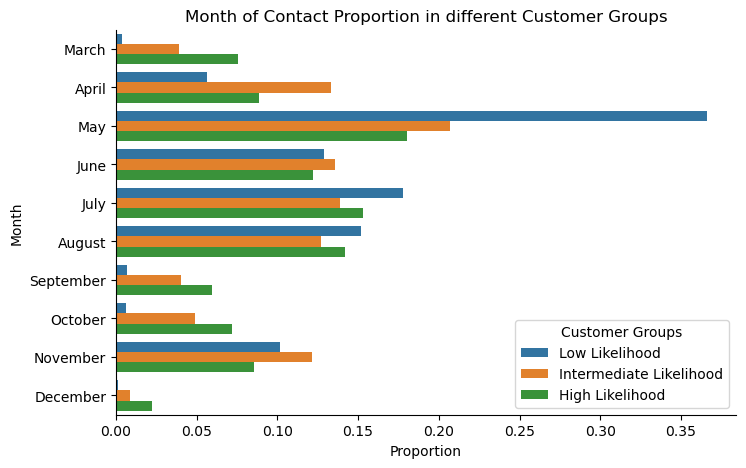

In [614]:
feat = 'month'

df_groups = [df_low, df_inter, df_high]
group_names = ['Low Likelihood', 'Intermediate Likelihood', 'High Likelihood']

df_customers_normlized = [df_group[feat].value_counts(normalize=True).reset_index() 
                          for df_group in df_groups]

for i, df in enumerate(df_customers_normlized):
    df['group'] = group_names[i]

combined_normalized = pd.concat(df_customers_normlized, ignore_index=True)

sorted_months = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
sorted_xlabels = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot the distribution of the categorical feature
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=combined_normalized, y=feat, x='proportion', hue='group',
            order=sorted_months)
ax.set_title('Month of Contact Proportion in different Customer Groups')
ax.set_xlabel('Proportion')
ax.set_ylabel('Month')
ax.legend(title='Customer Groups')

# Remove axes splines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.set_yticklabels(sorted_xlabels)

plt.show()

In some specific months (i.e March, September, October and December), sales employees should make more contact to customers as they are more success months.

### Insights from contact duration

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



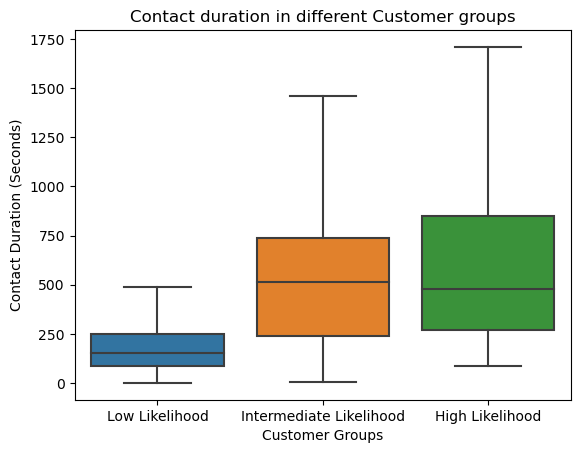

In [621]:
feat = 'duration'

fig, ax = plt.subplots()
sns.boxplot(data=df_customers, x='group', y=feat, showfliers=False)
ax.set_xlabel('Customer Groups')
ax.set_ylabel('Contact Duration (Seconds)')
ax.set_title('Contact duration in different Customer groups')
plt.show()

The contact duration should be kept long enough (i.e more than 4 mintues) to increase the responsive likelihood of customers.

### Insights from Employment Varient Rate

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



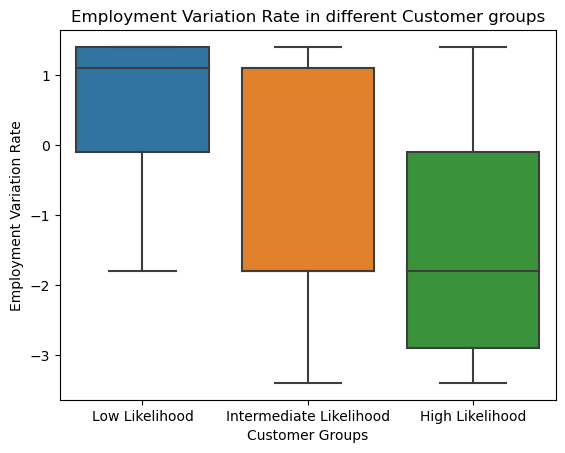

In [623]:
feat = 'emp.var.rate'

fig, ax = plt.subplots()
sns.boxplot(data=df_customers, x='group', y=feat, showfliers=False)
ax.set_xlabel('Customer Groups')
ax.set_ylabel('Employment Variation Rate')
ax.set_title('Employment Variation Rate in different Customer groups')
plt.show()

Business should launch the marketing campaign when the employment rate is low to increase the responsive likelihood of customers.

# Conclusions

In summary, the project developed different types of Machine Learning models to achieve the best performance on given test dataset. Several optimization techniques were used to enhance the model ability to capture 
as many responsive customers as possibe with acceptable precision. Based on the best model, some insights and strategies for business marketing campaign were generated:

1. The company should focus in customers who already response to the previous marketing campaign to increase the success likelihood.
2. In some specific months (i.e March, September, October and December), sales employees should make more contact to customers as they are more success months.
3. The contact duration should be kept long enough (i.e more than 4 mintues) to increase the responsive likelihood of customers.
4. Business should launch the marketing campaign when the employment rate is low to increase the responsive likelihood of customers.